# Обучение с учителем. Классификация. Дискриминантный анализ. Логистическая регрессия. Метод опорных векторов. Выбор модели с помощью кросс-валидации. Метод стохастического градиента

Выполнили: Редкокош Кирилл, Белкова Анна, Лобанова Полина

Подключаем все необходимые библиотеки (и заодно что-то лишнее, вдруг пригодится):

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks

from sklearn. model_selection import train_test_split
from sklearn. model_selection import RepeatedStratifiedKFold
from sklearn. model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn. discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from typing import Dict
random.seed(1)
sns.set_theme(style="ticks")

# Первичная обработка данных

Запишем данные в dataframe, переменную "качество" будем рассматривать как классифицирующую 
(на 2 класса- качество вина ниже 6 или выше) и выведем первые 5 строк:

In [3]:
df = pd.read_csv('winequality-red2.csv', delimiter=',')
df = df.assign(quality = df['quality'] >= 6)
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4    False  
1      9.8    False  
2      9.8    False  
3      9.8     True  
4      9.4    False

Удалим из рассмотрения free.sulfur.dioxide, так как есть total.sulfur.dioxide и удалим citric.acid, так как есть fixed.acidity.

In [4]:
df1 = df[['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']]
df1_train, df1_test = train_test_split(df1, test_size=0.2)

Проверим соотношение классов:

In [5]:
df1_train['quality'].value_counts()

True     695
False    584
Name: quality, dtype: int64

In [6]:
df1_test['quality'].value_counts()

False    160
True     160
Name: quality, dtype: int64

In [7]:
Xtrain = df1_train.drop('quality', axis=1)
ytrain = df1_train[['quality']]
Xtest = df1_test.drop('quality', axis=1)
ytest = df1_test['quality']

Представим наши данные на парном графике:

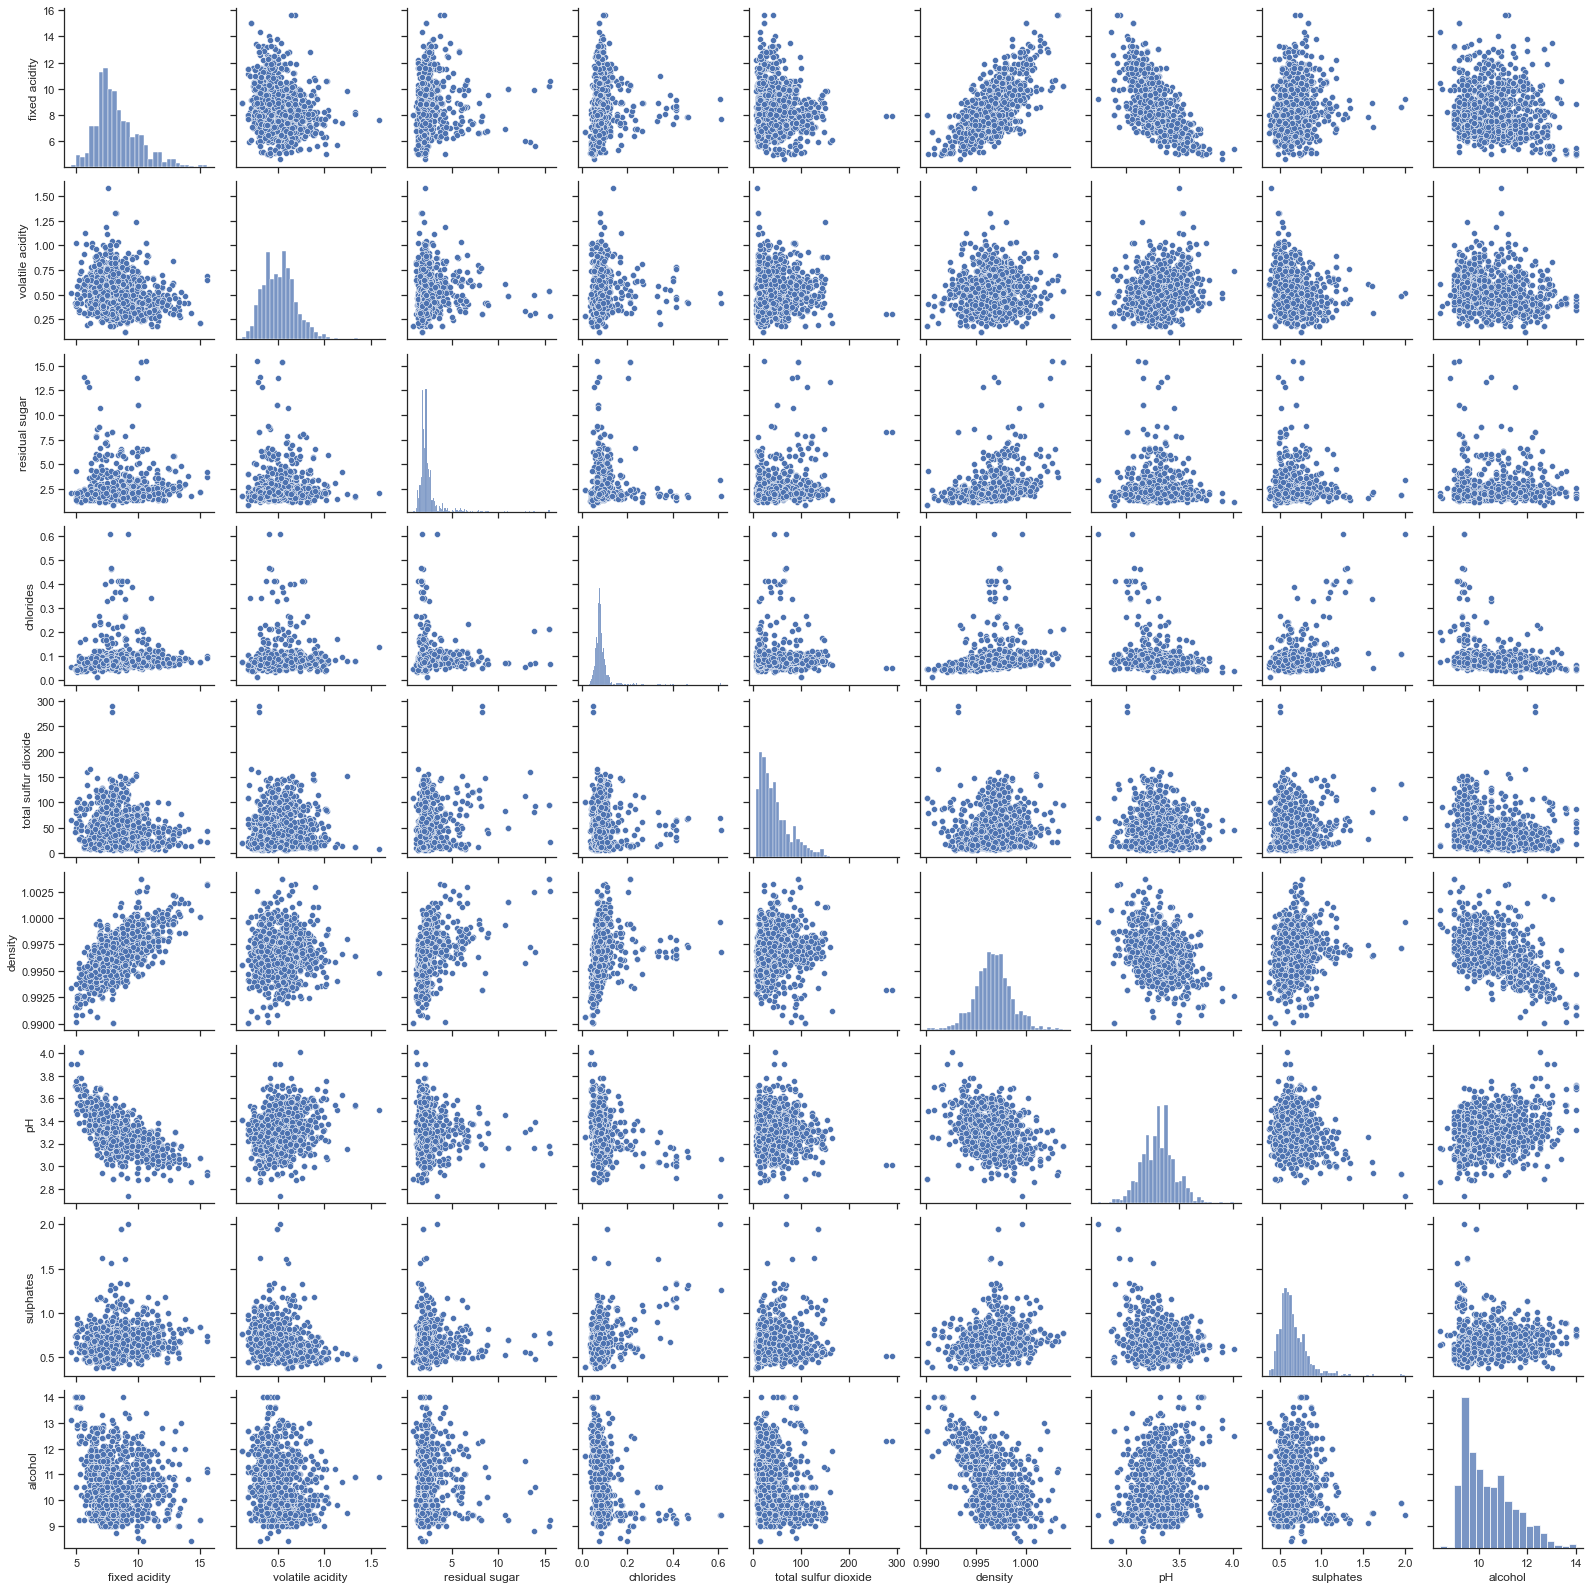

In [8]:
plt.show(sns.pairplot(df1_train.iloc[:, :-1]))

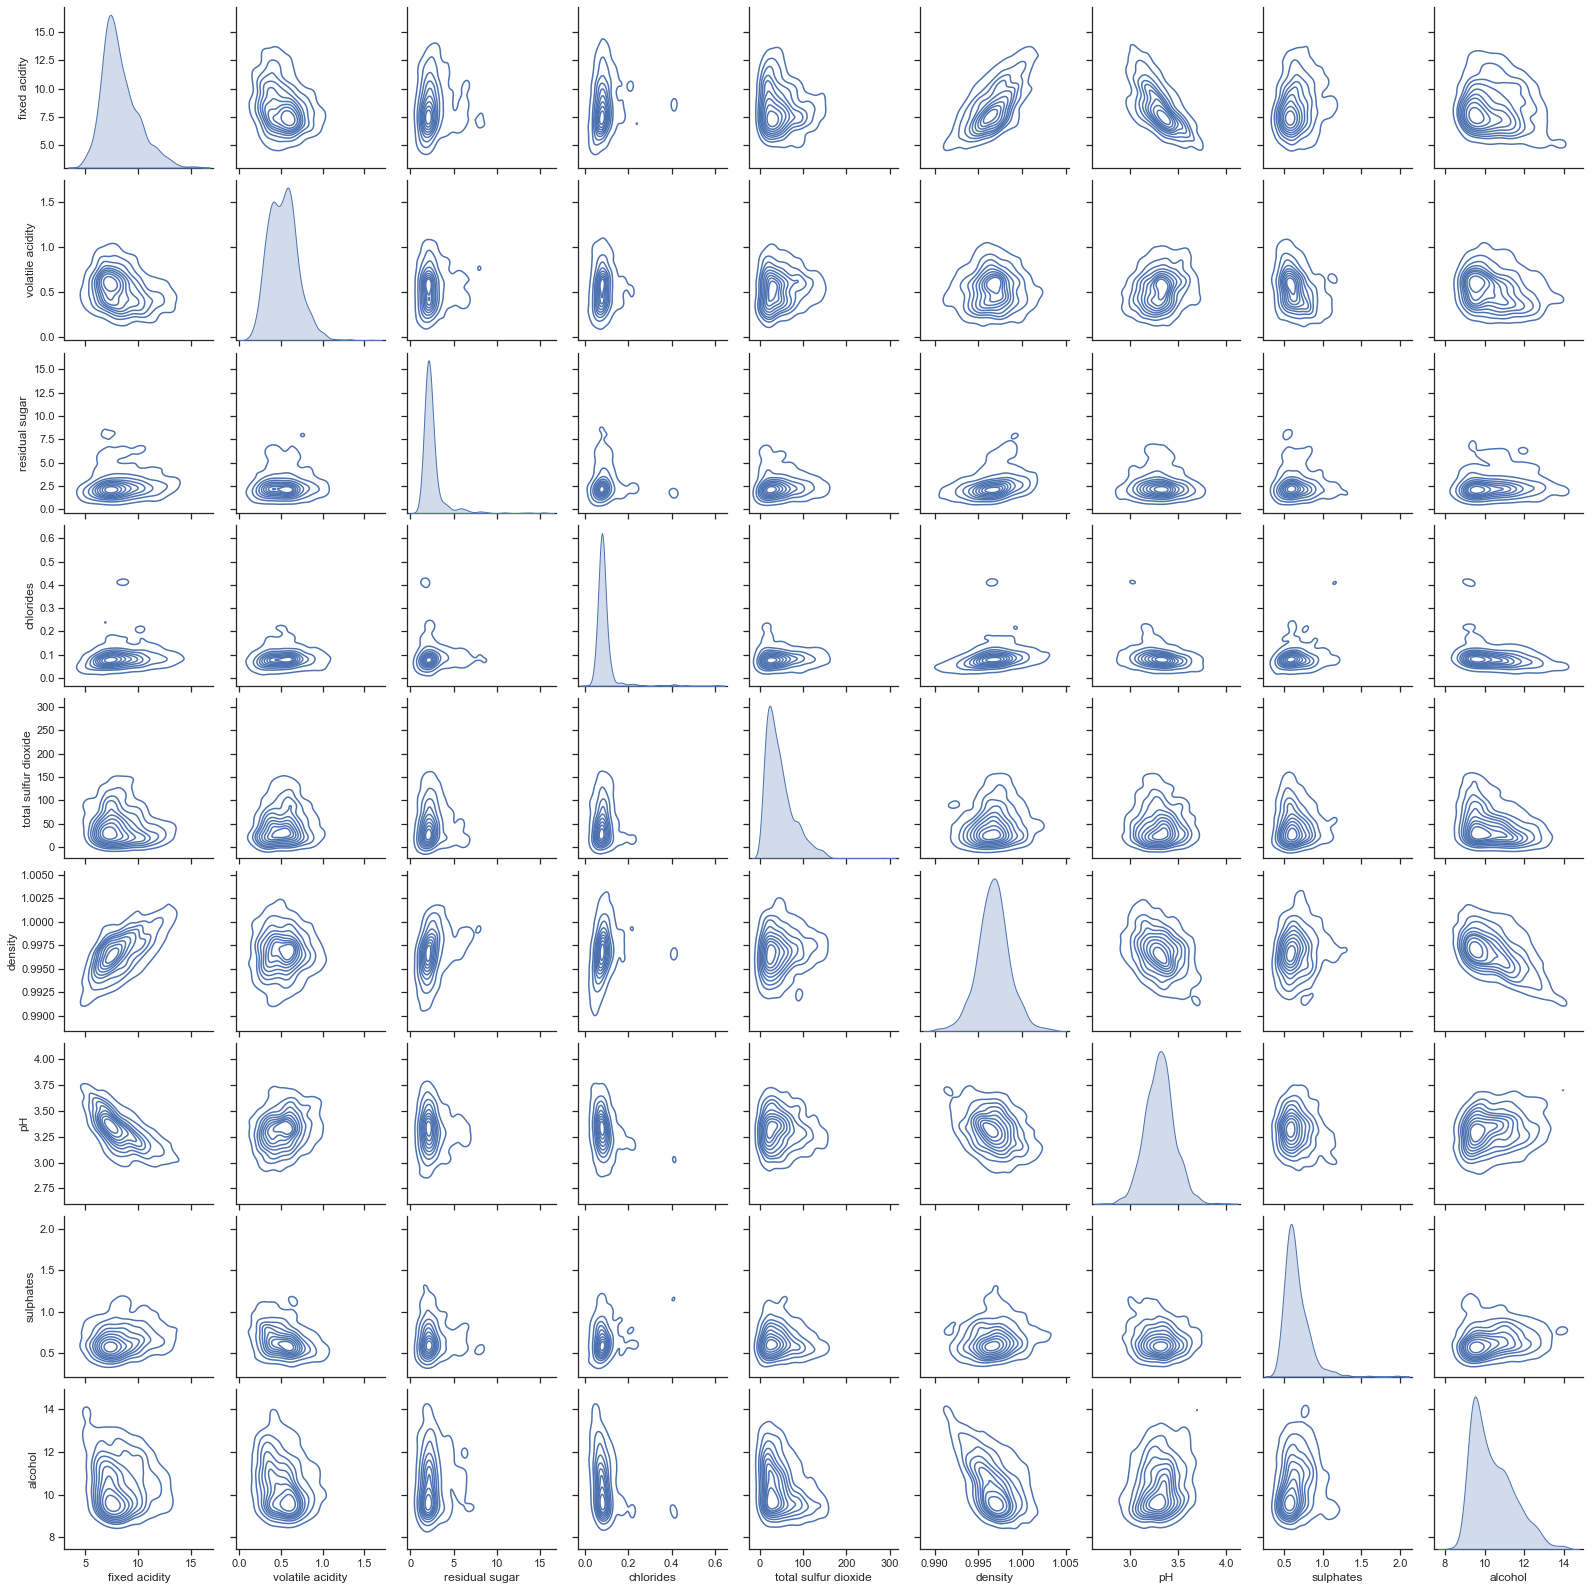

In [9]:
plt.show(sns.pairplot(df1_train.iloc[:, :-1], kind="kde"))

Прологарифмируем 1, 3, 4, 5, 8, 9. И снова изобразим данные, теперь уже с расскраской по нашей классифицирующей переменной:

In [10]:
df1_train.insert(1, 'fixed_acidity_log', np.log(df1_train['fixed acidity']))
df1_train.insert(1, 'residual_sugar_log', np.log(df1_train['residual sugar']))
df1_train.insert(1, 'volatile_acidity', df1_train['volatile acidity'])
df1_train.insert(1, 'chlorides_log', np.log(df1_train['chlorides']))
df1_train.insert(1, 'total_sulfur_dioxide_log', np.log(df1_train['total sulfur dioxide']))
df1_train.insert(1, 'pH_log', np.log(df1_train['pH']))
df1_train.insert(1, 'sulphates_log', np.log(df1_train['sulphates']))
df1_train.insert(1, 'alcohol_log', np.log(df1_train['alcohol']))

In [11]:
df1_train = df1_train.drop(['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol'], axis = 1)

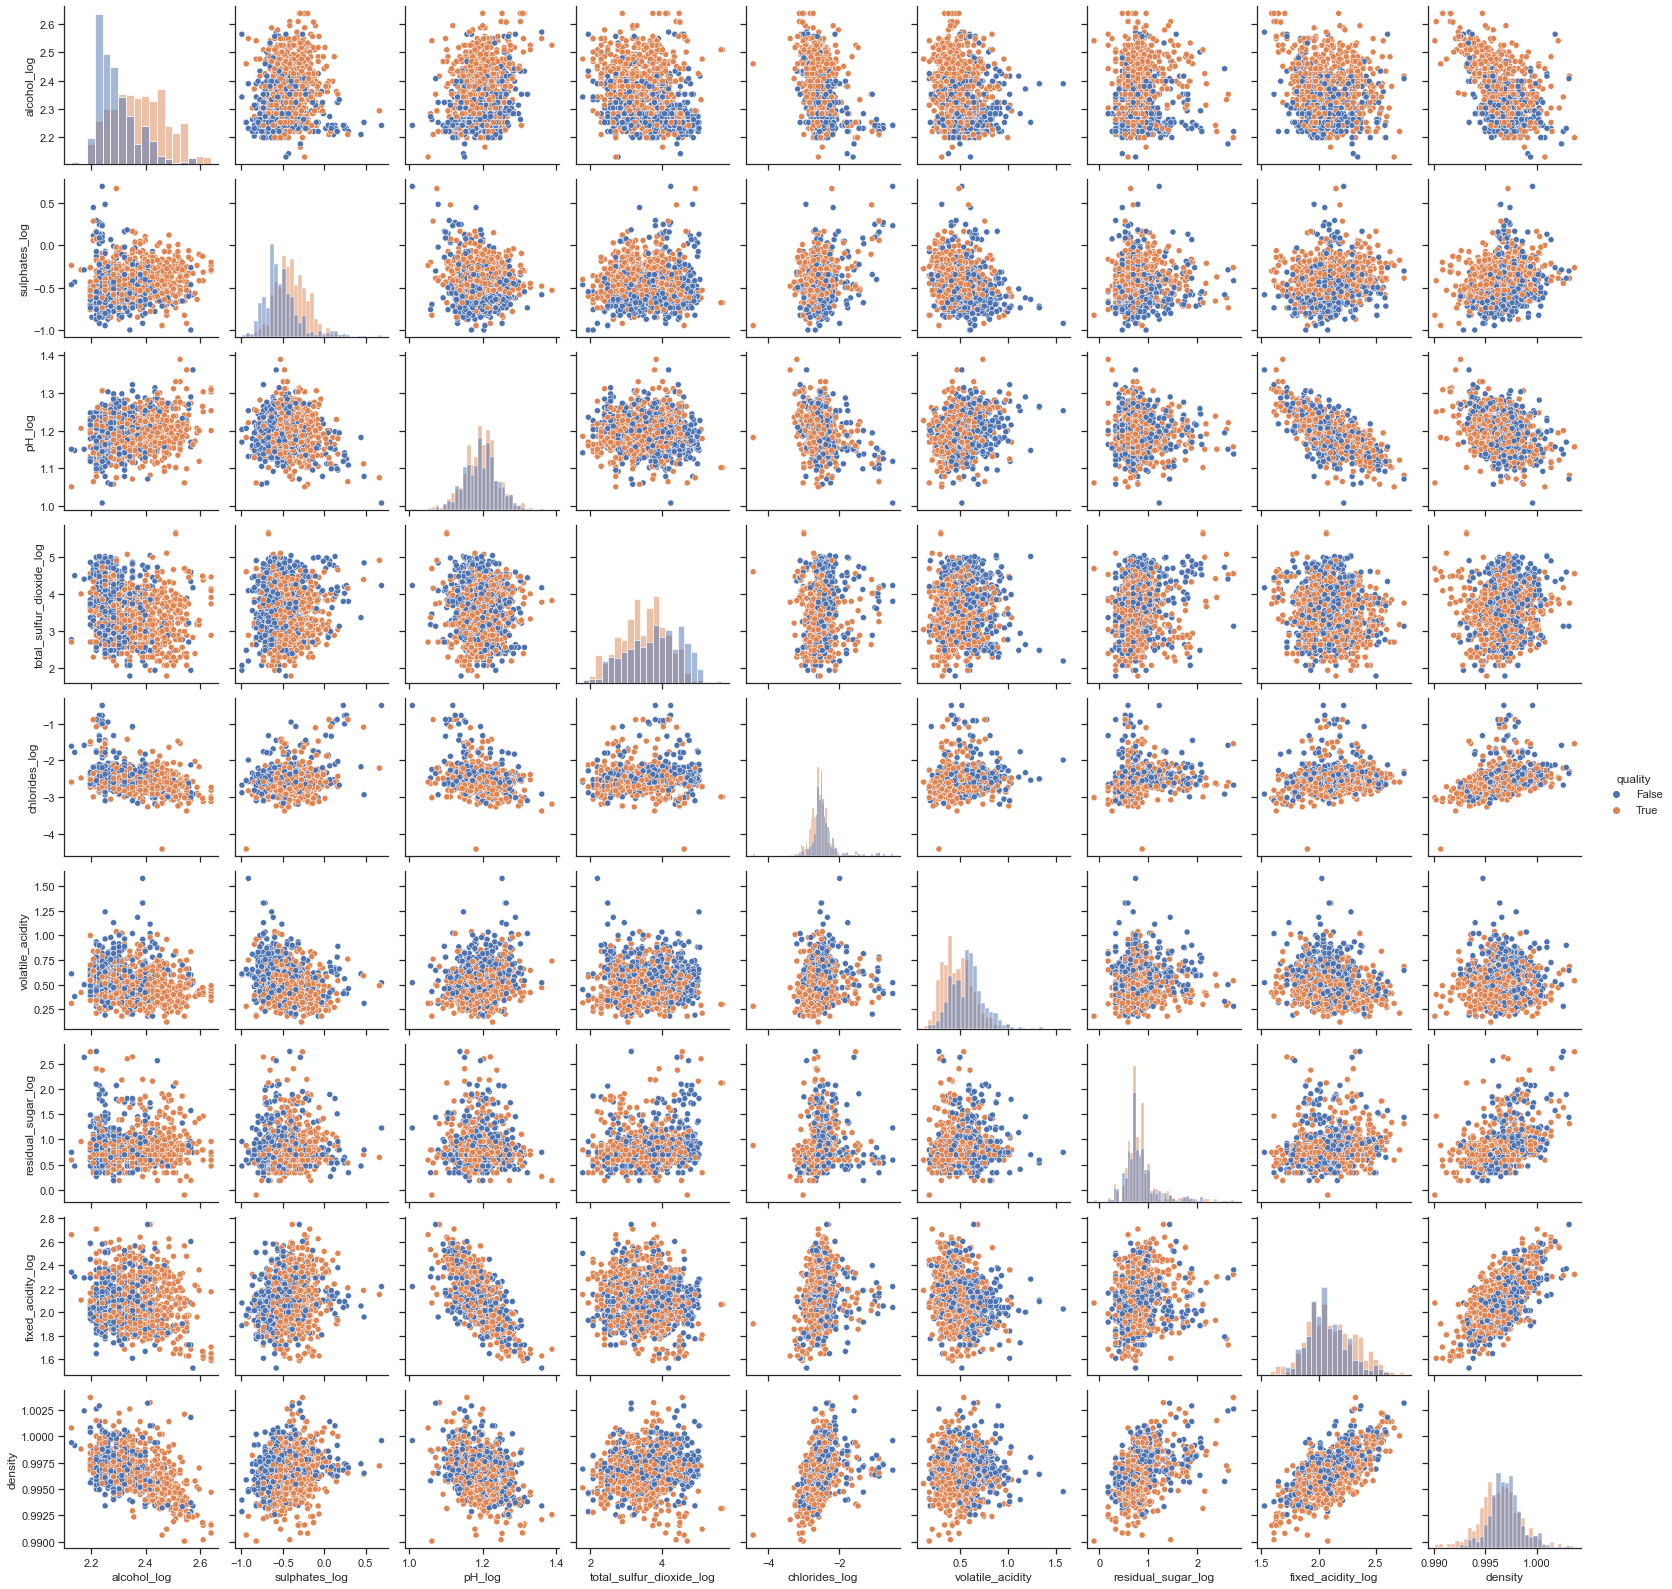

In [12]:
plt.show(sns.pairplot(df1_train, hue = 'quality', diag_kind='hist'))

Наблюдаем несколько выбросов, удалим их:

In [13]:
df1_train = df1_train.drop(df1_train[df1_train.chlorides_log < -4].index)
df1_train = df1_train.drop(df1_train[df1_train.total_sulfur_dioxide_log > 5.1].index)
df1_train = df1_train.drop(df1_train[df1_train.alcohol_log > 2.7].index)
df1_train['quality'].value_counts()

True     690
False    584
Name: quality, dtype: int64

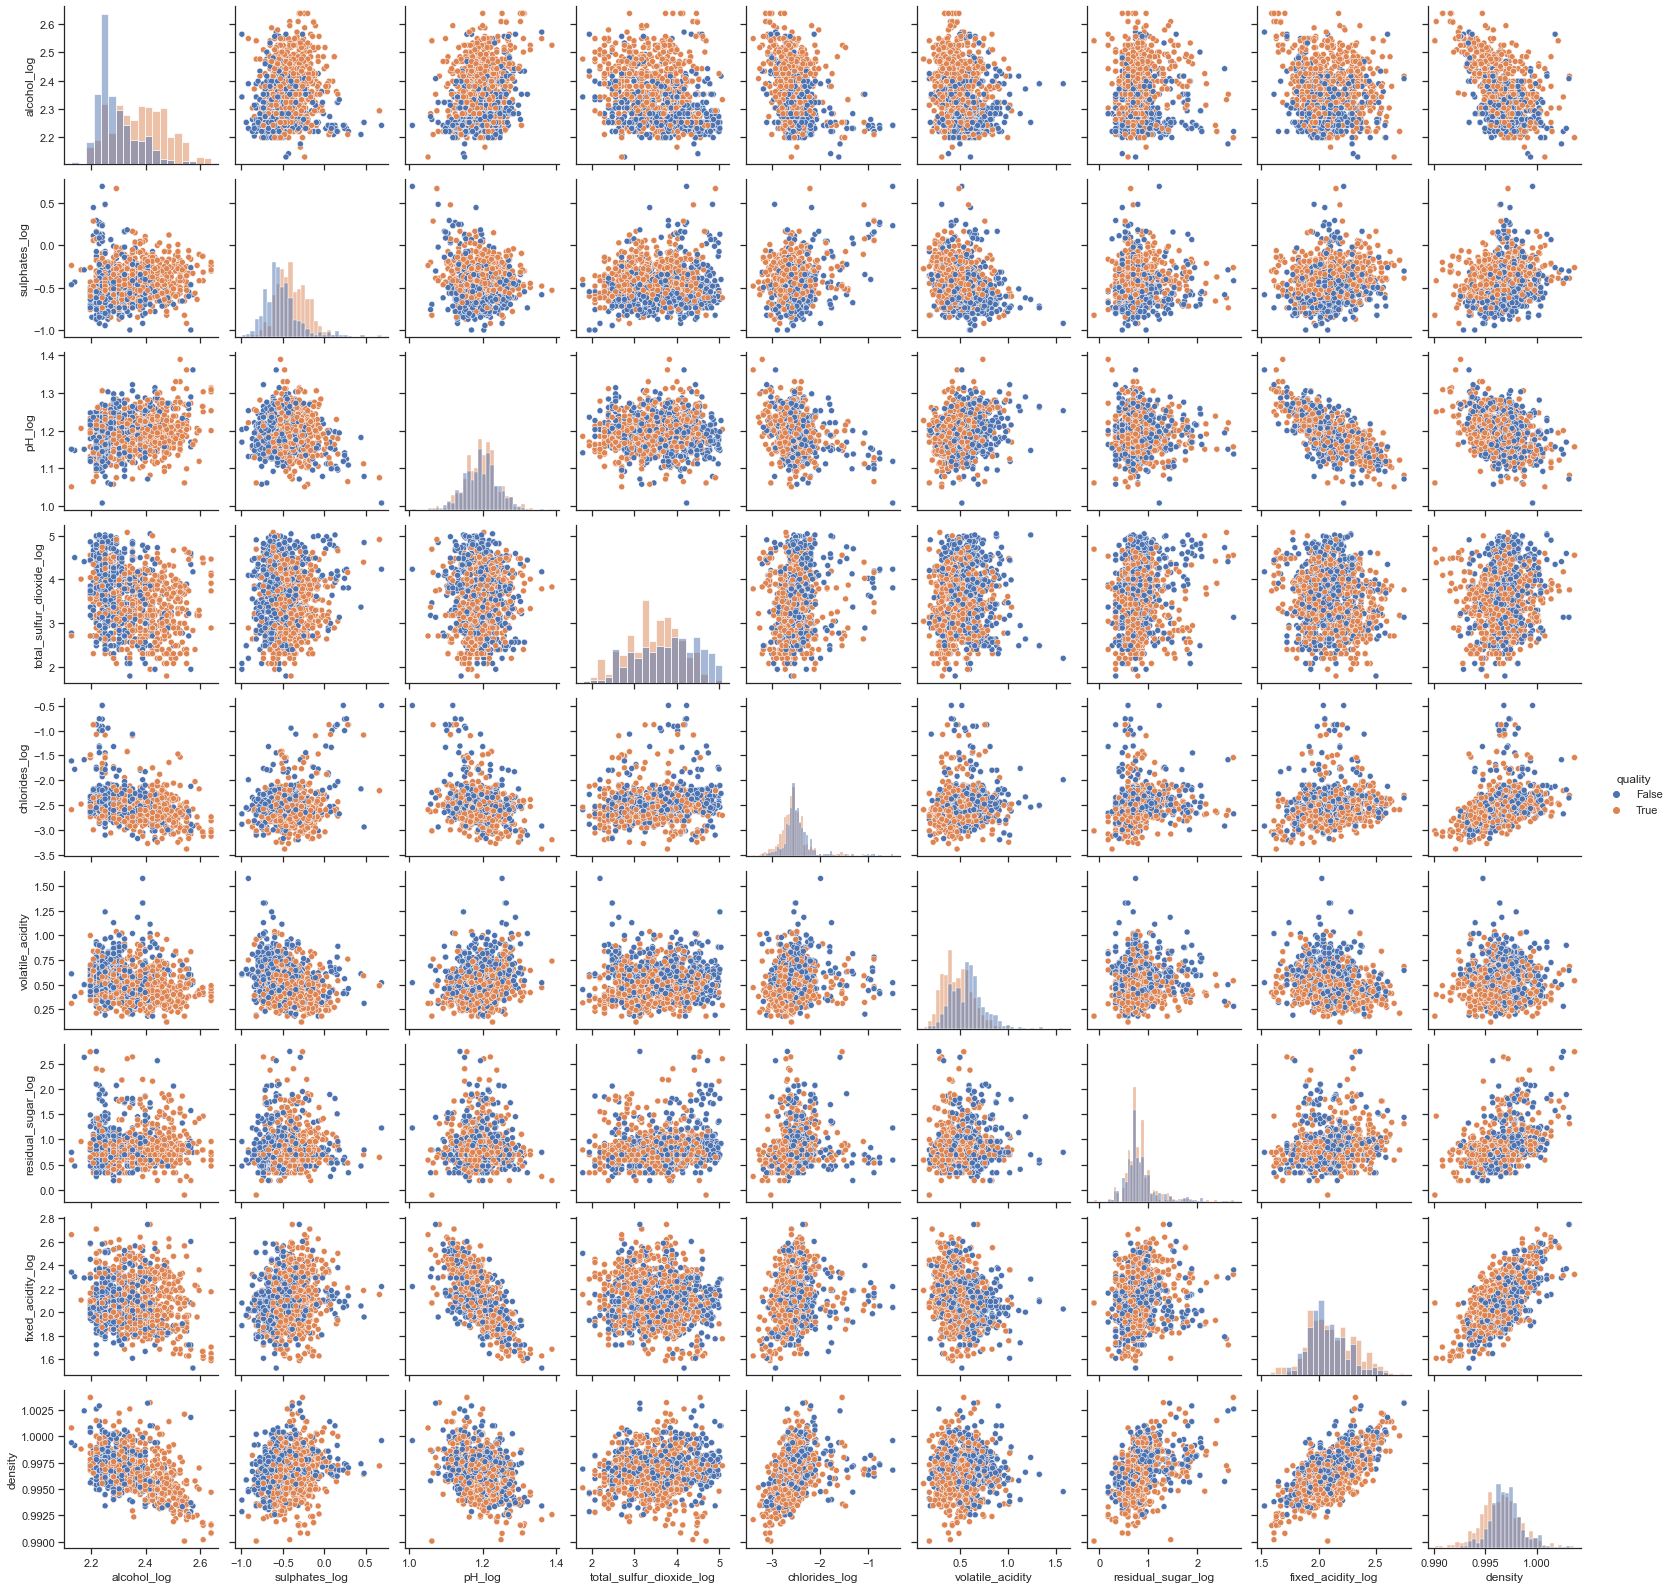

In [14]:
plt.show(sns.pairplot(df1_train, hue = 'quality', diag_kind='hist'))

In [15]:
df1_test.insert(1, 'fixed_acidity_log', np.log(df1_test['fixed acidity']))
df1_test.insert(1, 'residual_sugar_log', np.log(df1_test['residual sugar']))
df1_test.insert(1, 'volatile_acidity', df1_test['volatile acidity'])
df1_test.insert(1, 'chlorides_log', np.log(df1_test['chlorides']))
df1_test.insert(1, 'total_sulfur_dioxide_log', np.log(df1_test['total sulfur dioxide']))
df1_test.insert(1, 'pH_log', np.log(df1_test['pH']))
df1_test.insert(1, 'sulphates_log', np.log(df1_test['sulphates']))
df1_test.insert(1, 'alcohol_log', np.log(df1_test['alcohol']))
df1_test = df1_test.drop(['fixed acidity', 'volatile acidity','residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol'], axis = 1)

In [16]:
X_train, Y_train =  df1_train.iloc[:, :-1], df1_train.iloc[:, -1]
X_test, Y_test = df1_test.iloc[:, :-1], df1_test.iloc[:, -1]

## Дискриминантный анализ

Предположим, что ковариационные матрицы двух групп равны и проведем линейный дискриминантный анализ.

In [17]:
lda = LinearDiscriminantAnalysis()
lda.fit(df1_train.iloc[:, :-1], df1_train['quality'])
print('train accuracy:',lda.score(df1_train.iloc[:, :-1], df1_train['quality']))
print('test accuracy:',lda.score(df1_test.iloc[:, :-1], df1_test['quality']))
lda_pr = lda.predict(df1_test.iloc[:, :-1])
print(classification_report(df1_test['quality'], lda_pr))
print(roc_auc_score(df1_test['quality'], lda_pr))

train accuracy: 0.7307692307692307
test accuracy: 0.771875
              precision    recall  f1-score   support

       False       0.80      0.72      0.76       160
        True       0.75      0.82      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320

0.771875


Так как классы достаточно сбалансированы, то мы можем использовать accuracy как метрику качества классификации.

Точность на тестовом наборе около 74%.

Проверим значимость дискриминации.

In [18]:
from statsmodels.multivariate.manova import MANOVA
maov=MANOVA.from_formula('fixed_acidity_log + volatile_acidity + residual_sugar_log + chlorides_log + total_sulfur_dioxide_log + density + pH_log + sulphates_log + alcohol_log ~ quality', data=df1_train)
print(maov.mv_test())

                        Multivariate linear model
                                                                          
--------------------------------------------------------------------------
       Intercept           Value    Num DF   Den DF     F Value     Pr > F
--------------------------------------------------------------------------
          Wilks' lambda      0.0000 9.0000 1264.0000 129641738.4038 0.0000
         Pillai's trace      1.0000 9.0000 1264.0000 129641738.4038 0.0000
 Hotelling-Lawley trace 923081.9981 9.0000 1264.0000 129641738.4038 0.0000
    Roy's greatest root 923081.9981 9.0000 1264.0000 129641738.4038 0.0000
--------------------------------------------------------------------------
                                                                          
----------------------------------------------------------------------------
            quality           Value    Num DF     Den DF    F Value   Pr > F
----------------------------------------------

p-value во всех случаях близок к 0, гипотеза о значимости не отвергается.

Предположим, что ковариационные матрицы двух групп различны и проведем квадратичный дискриминантный анализ.

In [19]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(df1_train.iloc[:, :-1], df1_train['quality'])
print('train accuracy:', qda.score(df1_train.iloc[:, :-1], df1_train['quality']))
print('test accuracy:', qda.score(df1_test.iloc[:, :-1], df1_test['quality']))
qda_pr = qda.predict(df1_test.iloc[:, :-1])
print(classification_report(df1_test['quality'], qda_pr))
print(roc_auc_score(df1_test['quality'], qda_pr))

train accuracy: 0.7488226059654631
test accuracy: 0.765625
              precision    recall  f1-score   support

       False       0.80      0.71      0.75       160
        True       0.74      0.82      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.76       320
weighted avg       0.77      0.77      0.76       320

0.765625


Качество классификации на тестовом наборе немного уменьшилось в сравнении с lda. 
При этом стоит помнить, что для этого нам понадобилось оценить намного больше параметров.

Перейдем к модели наивного байесовского классификатора:

In [20]:
gnb = GaussianNB()
gnb.fit(df1_train.iloc[:, :-1], df1_train['quality'])
print('train accuracy:',gnb.score(df1_train.iloc[:, :-1], df1_train['quality']))
print('test accuracy:',gnb.score(df1_test.iloc[:, :-1], df1_test['quality']))
gnb_pr = lda.predict(df1_test.iloc[:, :-1])
print(classification_report(df1_test['quality'], gnb_pr))
print(roc_auc_score(df1_test['quality'], gnb_pr))

train accuracy: 0.7409733124018838
test accuracy: 0.790625
              precision    recall  f1-score   support

       False       0.80      0.72      0.76       160
        True       0.75      0.82      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320

0.771875


Эта модель показала лучший результат.

## Метод опорных векторов

In [21]:
C = 1  # параметр регуляризации

Для начала попробуем классический SVС (с линейной разделяющей плоксотью)

In [22]:
model_linear = svm.SVC(kernel='linear', C=C)
model_linear.fit(X_train, Y_train)

print('train accuracy:', model_linear.score(X_train, Y_train))
print('test accuracy:',model_linear.score(X_test, Y_test))

y_predict = model_linear.predict(X_test)

print(classification_report(Y_test, y_predict))
print('roc-auc score:', roc_auc_score(Y_test, y_predict))

train accuracy: 0.7378335949764521
test accuracy: 0.753125
              precision    recall  f1-score   support

       False       0.78      0.70      0.74       160
        True       0.73      0.81      0.77       160

    accuracy                           0.75       320
   macro avg       0.76      0.75      0.75       320
weighted avg       0.76      0.75      0.75       320

roc-auc score: 0.7531249999999999


В качестве одного из параметров мы можем выбрать ядро.
В реализации sklearn помимо линейного ядра можно выбрать радиальное, полиномиальное, сигмовидное ядро или написать свою функцию.
Поскольку ярко выраженной зависимости в данных не наблюдается, попробуем нелинейные ядра.

In [23]:
model_rbf = svm.SVC(kernel='rbf', C=C)
model_rbf.fit(X_train, Y_train)

print('train accuracy:', model_rbf.score(X_train, Y_train))
print('test accuracy:',model_rbf.score(X_test, Y_test))

y_predict = model_rbf.predict(X_test)

print(classification_report(Y_test, y_predict))
print('roc-auc score:', roc_auc_score(Y_test, y_predict))

train accuracy: 0.7182103610675039
test accuracy: 0.70625
              precision    recall  f1-score   support

       False       0.77      0.59      0.67       160
        True       0.67      0.82      0.74       160

    accuracy                           0.71       320
   macro avg       0.72      0.71      0.70       320
weighted avg       0.72      0.71      0.70       320

roc-auc score: 0.7062499999999999


In [24]:
model_poly = svm.SVC(kernel='poly', degree=7, C=C)
model_poly.fit(X_train, Y_train)

print('train accuracy:', model_poly.score(X_train, Y_train))
print('test accuracy:',model_poly.score(X_test, Y_test))

y_predict = model_poly.predict(X_test)

print(classification_report(Y_test, y_predict))
print('roc-auc score:', roc_auc_score(Y_test, y_predict))

train accuracy: 0.749607535321821
test accuracy: 0.7625
              precision    recall  f1-score   support

       False       0.80      0.71      0.75       160
        True       0.74      0.82      0.78       160

    accuracy                           0.76       320
   macro avg       0.77      0.76      0.76       320
weighted avg       0.77      0.76      0.76       320

roc-auc score: 0.7625000000000001


In [25]:
model_sigm = svm.SVC(kernel='sigmoid', C=C)
model_sigm.fit(X_train, Y_train)

print('train accuracy:', model_sigm.score(X_train, Y_train))
print('test accuracy:',model_sigm.score(X_test, Y_test))

y_predict = model_sigm.predict(X_test)

print(classification_report(Y_test, y_predict))
print('roc-auc score:', roc_auc_score(Y_test, y_predict))

train accuracy: 0.5863422291993721
test accuracy: 0.5375
              precision    recall  f1-score   support

       False       0.88      0.09      0.16       160
        True       0.52      0.99      0.68       160

    accuracy                           0.54       320
   macro avg       0.70      0.54      0.42       320
weighted avg       0.70      0.54      0.42       320

roc-auc score: 0.5375000000000001


In [26]:
linear_cv_mean = cross_val_score(model_linear, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=5, scoring='accuracy').mean()
print(f'linear_mean: {linear_cv_mean}')

linear_mean: 0.7307302763625135


In [27]:
rbf_cv_mean = cross_val_score(model_rbf, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=5, scoring='accuracy').mean()
print(f'rbf_mean: {rbf_cv_mean}')

rbf_mean: 0.7181843446039834


In [28]:
poly_cv_mean = cross_val_score(model_poly, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=5, scoring='accuracy').mean()
print(f'poly_mean: {poly_cv_mean}')

poly_mean: 0.7448571869692759


In [29]:
sigm_cv_mean = cross_val_score(model_sigm, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=5, scoring='accuracy').mean()
print(f'sigm_mean: {sigm_cv_mean}')

sigm_mean: 0.5526046008954764


Таким образом, в данной задаче лучше всех себя показали алгоритмы с полиномиальным и линейным ядром.

## Логистическая регрессия

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [31]:
df1_train.quality = df1_train.quality.astype(int)

In [32]:
df1_test.quality = df1_test.quality.astype(int)

Попробуем построить модель с разными методами оптимизации. Метод Ньютона-Рафсона:

In [33]:
model = LogisticRegression(random_state = 12345, solver = 'newton-cg')
model.fit(Xtrain, ytrain)
predicted = model.predict_proba(Xtest)[:, 1]
ypred = model.predict(Xtest)
result = roc_auc_score(ytest, predicted)
accuracy = model.score(Xtest, ytest)

print('AUC-ROC:', result)
print('accuracy:', accuracy)

AUC-ROC: 0.840859375
accuracy: 0.775


Метод стохастического градиента:

In [34]:
model = LogisticRegression(random_state = 12345, solver = 'sag')
model.fit(Xtrain, ytrain)
predicted = model.predict_proba(Xtest)[:, 1]
ypred = model.predict(Xtest)
result = roc_auc_score(ytest, predicted)
accuracy = model.score(Xtest, ytest)

print('AUC-ROC:', result)
print('accuracy:', accuracy)

AUC-ROC: 0.7139453124999999
accuracy: 0.61875


Coordinate Descent (CD) algorithm:

In [35]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(Xtrain, ytrain)
predicted = model.predict_proba(Xtest)[:, 1]
ypred = model.predict(Xtest)
result = roc_auc_score(ytest, predicted)
accuracy = model.score(Xtest, ytest)

print('AUC-ROC:', result)
print('accuracy:', accuracy)

AUC-ROC: 0.8414062500000001
accuracy: 0.7625


По умолчанию --- метод Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm (solver = 'lbfgs'). Аналог метода Ньютона, но гессиан вычисляется приближенно. 

In [36]:
model = LogisticRegression(random_state = 12345)
model.fit(Xtrain, ytrain)
predicted = model.predict_proba(Xtest)[:, 1]
ypred = model.predict(Xtest)
result = roc_auc_score(ytest, predicted)
accuracy = model.score(Xtest, ytest)

print('AUC-ROC:', result)
print('accuracy:', accuracy)

AUC-ROC: 0.839453125
accuracy: 0.7625


Оставим вариант по умолчанию, так как он показал наилучшие результаты.

In [37]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

       False       0.80      0.69      0.74       160
        True       0.73      0.83      0.78       160

    accuracy                           0.76       320
   macro avg       0.77      0.76      0.76       320
weighted avg       0.77      0.76      0.76       320



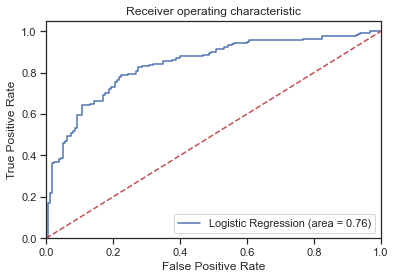

In [38]:
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytest, model.predict(Xtest))
fpr, tpr, thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Resampling

Искусствено уравняем число индивидов в классах.

Исходная выборка:

In [39]:
print('train accuracy:',gnb.score(df1_train.iloc[:, :-1], df1_train['quality']))
print('test accuracy:',gnb.score(df1_test.iloc[:, :-1], df1_test['quality']))
gnb_pr = lda.predict(df1_test.iloc[:, :-1])
print(classification_report(df1_test['quality'], gnb_pr))
print(roc_auc_score(df1_test['quality'], gnb_pr))

train accuracy: 0.7409733124018838
test accuracy: 0.790625
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       160
           1       0.75      0.82      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320

0.771875


Случайная наивная избыточная выборка:

In [40]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(df1_train.iloc[:, :-1], df1_train['quality'])

In [41]:
gnb.fit(X_resampled, y_resampled)
print('train accuracy:',gnb.score(X_resampled, y_resampled))
print('test accuracy:',gnb.score(df1_test.iloc[:, :-1], df1_test['quality']))
gnb_pr = lda.predict(df1_test.iloc[:, :-1])
print(classification_report(df1_test['quality'], gnb_pr))
print(roc_auc_score(df1_test['quality'], gnb_pr))

train accuracy: 0.7376811594202899
test accuracy: 0.784375
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       160
           1       0.75      0.82      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320

0.771875


Качество классификации стало немного выше, чем при использовании наивного байессовского классфикатора к исходной выборке.

In [42]:
X_resampled, y_resampled = SMOTE().fit_resample(df1_train.iloc[:, :-1], df1_train['quality'])

In [43]:
gnb.fit(X_resampled, y_resampled)
print('train accuracy:',gnb.score(X_resampled, y_resampled))
print('test accuracy:',gnb.score(df1_test.iloc[:, :-1], df1_test['quality']))
gnb_pr = lda.predict(df1_test.iloc[:, :-1])
print(classification_report(df1_test['quality'], gnb_pr))
print(roc_auc_score(df1_test['quality'], gnb_pr))

train accuracy: 0.7384057971014493
test accuracy: 0.78125
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       160
           1       0.75      0.82      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320

0.771875


Результаты совпадают со случайной избыточной выборкой.

In [44]:
X_resampled, y_resampled = TomekLinks().fit_resample(df1_train.iloc[:, :-1], df1_train['quality'])

In [46]:
gnb.fit(X_resampled, y_resampled)
print('train accuracy:',gnb.score(X_resampled, y_resampled))
print('test accuracy:',gnb.score(df1_test.iloc[:, :-1], df1_test['quality']))
gnb_pr = lda.predict(df1_test.iloc[:, :-1])
print(classification_report(df1_test['quality'], gnb_pr))
print(roc_auc_score(df1_test['quality'], gnb_pr))

train accuracy: 0.7461097461097461
test accuracy: 0.78125
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       160
           1       0.75      0.82      0.78       160

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320

0.771875


Результаты совпадают со случайной избыточной выборкой.

Resampling незначительно улучшил качество классификации во всех трех случаях.

# Cross-validation

Будем рассматривать модель наивного байесовского классификатора с различными cv.

In [47]:
print(cross_val_score(gnb, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=3, scoring='accuracy'))
print(cross_val_score(gnb, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=3, scoring='accuracy').mean())

[0.76235294 0.72705882 0.7240566 ]
0.7378227894931557


In [48]:
print(cross_val_score(gnb, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=7, scoring='accuracy').mean())

0.7331240188383046


In [49]:
print(cross_val_score(gnb, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=13, scoring='accuracy').mean())

0.7323390894819466


In [50]:
print(cross_val_score(gnb, X=df1_train.iloc[:, :-1], y=df1_train['quality'], cv=int(len(df1_train['quality'])/2), scoring='accuracy').mean())

0.7378335949764521


Во всех случаях при кросс-валидации accuracy ≈ 73.5%.